In [1]:
import sys
from pathlib import Path
sys.path.append(Path.cwd().parent.__str__())

### DRRU-Net Demo
- transfer model (backbone pre-train)
- non-transfer model

In [2]:
import os
import torch
import matplotlib.pyplot as plt
import numpy as np

import torch.nn.functional as F
from model.unet_model import Ringed_Res_Unet,DCT_RRUnet 
from dataset.Defacto import * # defacto 데이터셋 한정 테스트 모듈
from loss.dice_loss import SoftDiceLoss
from predict import test_dataset_dice

In [8]:
# data configs
MODE = 'te1st' # 'any' : no purmute , no normalize / 'test' same 'train' condition
IMG_SIZE = 512
INDEX =  631 # 654 1333,sp,cp / 333cp / casia2312
DIR_IMGS = {
        "defacto_splicing_test":r"F:\datasets\Defacto_splicing\splicing_3_img\img_jpg",
        "defactor_copy_move":r"F:\datasets\defacto_copy_move\copymove_img\img_jpg",
        "casia":r"F:\datasets\CASIA2.0\Tp_jpg"
        }
DIR_MASKS = {
    "defacto_splicing_test":r"F:\datasets\Defacto_splicing\splicing_3_annotations\probe_mask",
    "defactor_copy_move":r"F:\datasets\defacto_copy_move\copymove_annotations\probe_mask",
    "casia":r"F:\datasets\CASIA2.0\Groundtruth_jpg"
    }

DT = "casia"
DIR_IMG = DIR_IMGS[DT]

DIR_MASK = DIR_MASKS[DT]

In [10]:
# utills 

def get_confusion_matrix(label, pred, size, num_class, ignore=-1):
    """
    Calcute the confusion matrix by given label and pred
    """
    output = (pred.squeeze(0).cpu().numpy() > 0.5).astype(np.int32)
    seg_pred = np.asarray(output[:, :size[-2], :size[-1]], dtype=np.int32)
    seg_gt = np.asarray(
    label.cpu().numpy()[:, :size[-2], :size[-1]], dtype=np.int32)
    ignore_index = seg_gt != ignore
    seg_gt = seg_gt[ignore_index]
    seg_pred = seg_pred[ignore_index]
    index = (seg_gt * num_class + seg_pred).astype('int32')
    label_count = np.bincount(index)
    cm = np.zeros((num_class, num_class))

    for i_label in range(num_class):
        for i_pred in range(num_class):
            cur_index = i_label * num_class + i_pred
            if cur_index < len(label_count):
                cm[i_label,i_pred] = label_count[cur_index]
    return cm

def dice_coeff_loss_2(pred, target):
    smooth = 1e-7
    h,w=512,512
    img = target.cpu().numpy()
    for i in range(len(img)-1,0,-1):
        if img[0,i]!=-1.:
            w = i  
            break
    for i in range(len(img)-1,0,-1):
        if img[i,0]!=-1.:
            h = i  
            break
    pred = (pred[:h,:w] >0.5).float()
    target = (target[:h,:w] > 0.5).float()
    num = pred.size(0)
    m1 = pred.view(num, -1)  # Flatten
    m2 = target.view(num, -1)  # Flatten
    intersection = (m1 * m2).sum()

    return (2. * intersection) / (m1.sum() + m2.sum() + smooth)

def plot_result(model,name,idx):
    device = torch.device("cuda:0")
    if name in "DCT_RRUnet":
        pred,img,mask = test_dct(model,device,idx,MODE,IMG_SIZE,DIR_IMG,DIR_MASK)
    else:
        pred,img,mask = test(model,device,idx,MODE,IMG_SIZE,DIR_IMG,DIR_MASK)
       
    pred = F.sigmoid(pred)
    label = mask.squeeze(0)
    pred = torch.squeeze(pred, 0)
    pred = pred.squeeze(0)
    dice_coef = dice_coeff_loss_2(pred,(mask.to(device) > 0.5).float()) 
    print("dice coff : ",dice_coef)
    pred_ = pred.to('cpu').detach().numpy()

    
    pred_ = pred_[:img.shape[0],:img.shape[1]]
    mask = mask[:img.shape[0],:img.shape[1]]

    plt.figure(figsize=(10,2))
    plt.subplot(141)
    plt.imshow(img)
    plt.title('Input')
    plt.axis('off')

    plt.subplot(142)
    plt.imshow(torch.relu(mask))
    plt.title('Ground Truth')
    plt.axis('off')

    plt.subplot(143)
    plt.imshow(pred_>0.5)#,cmap='jet',interpolation='nearest')
    plt.title('Predict')
    plt.axis('off')

    plt.subplot(144)
    plt.imshow(img)
    plt.imshow(pred_ ,alpha=0.6,cmap='jet')
    plt.title('Heatmap')
    
    plt.axis('off')
    plt.show()


dice coff :  tensor(0.9277, device='cuda:0')


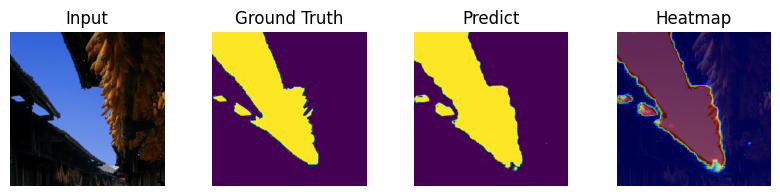

In [11]:
# model load : original
model_folder = '../result/logs/defactor/DCT_RRUnet_nonfreeze_1/'
model_name = 'DCT-[val_dice]-0.9039-[train_loss]-0.0907-ep6.pkl'

dct_rrunet_ori = DCT_RRUnet(mode='ori').cpu()
dct_rrunet_ori.load_state_dict(torch.load(os.path.join(model_folder,model_name)))

plot_result(dct_rrunet_ori.cuda(),'DCT_RRUnet', idx=INDEX)


dice coff :  tensor(0.9042, device='cuda:0')


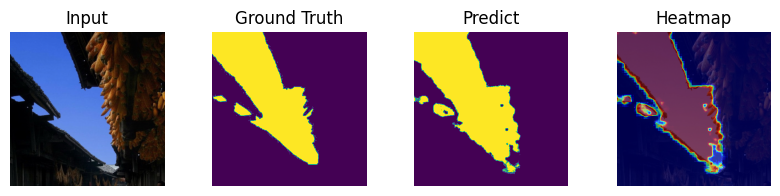

In [12]:
# model load : leaky relu model
model_folder = '../result/logs/defactor/DCT_RRUnet_nonfreeze_2/'
model_name = 'DCT-[val_dice]-0.9002-[train_loss]-0.0739-ep22.pkl'

dct_rrunet_lr = DCT_RRUnet(mode='trans').cpu()
dct_rrunet_lr.load_state_dict(torch.load(os.path.join(model_folder,model_name)))

plot_result(dct_rrunet_ori.cuda(),'DCT_RRUnet', idx=INDEX)


dice coff :  tensor(0.0564, device='cuda:0')


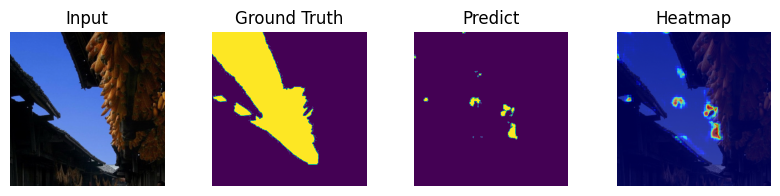

In [15]:
# model load : tr model
model_folder = '../result/logs/defactor/DCT_RRUnet/'
model_name = 'DCT-[val_dice]-0.9011-[train_loss]-0.0902-ep6.pkl'

dct_rrunet_tr = DCT_RRUnet(mode='ori').cpu()
dct_rrunet_tr.load_state_dict(torch.load(os.path.join(model_folder,model_name)))

plot_result(dct_rrunet_tr.cuda(),'DCT_RRUnet', idx=INDEX)
